In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from schedulers import LinearScheduler,CosineScheduler
from unet import UNetTimed, UNetTimedWithVAEConditioned
from schedulers import DDPM
from schedulers import DDIMSampler,DDPMSampler
from vae import VAE
from fid import FIDScore


fid_calculator = FIDScore()

mnist_dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


/home/nazara/Data2/UCU/CV_GENAI_2_3/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nazara/Data2/UCU/CV_GENAI_2_3/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
vae_model = VAE(latent_dim=64)
vae_model.load_state_dict(torch.load('vae_model2.pth'))
vae_model.eval()

for param in vae_model.parameters():
    param.requires_grad = False

unet = UNetTimedWithVAEConditioned(vae_model, use_condition=True)

# vae_model.encoder(torch.randn(1, 1, 28, 28))
# unet(torch.randn(1, 1, 28, 28), torch.randint(0, 1000, (1,)))


/tmp/ipykernel_69646/442564547.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load('vae_model2.pth'))


In [4]:
# Create DataLoader
batch_size = 128
dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Initialize model, optimizer and loss function
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-5)
mse_loss = torch.nn.MSELoss()

# Training hyperparameters
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device)

# DDPM instance
ddpm = DDPMSampler()
unconditional_prob = 0.1
fid_history = []
loss_history = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        latent_images = unet.encode_vae(images)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Generate random noise
        noise = torch.randn_like(latent_images).to(device)
        use_condition = torch.rand(labels.size()) < unconditional_prob
        condition = torch.where(use_condition, torch.zeros_like(labels)-1, labels)
        condition = condition.to(device)
        
        # Generate random timesteps
        batch_size = latent_images.shape[0]
        timesteps = torch.randint(0, ddpm.max_timestep, (batch_size,), device=device)
        
        # Add noise to images according to timesteps
        noised_images = ddpm.add_noise(latent_images, timesteps, noise)
        
        # Predict noise
        predicted_noise = unet(noised_images, timesteps, condition)
        
        # Calculate loss
        loss = mse_loss(predicted_noise, noise)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch} | Batch {batch_idx} | Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch} | Average Loss: {avg_loss:.4f}')
    

    with torch.no_grad():
        #create condition half -1 meaning unconditional, and half random 0-9
        condition = torch.cat([torch.full((batch_size // 2,), -1, dtype=torch.long),
                                torch.randint(0, 10, (batch_size // 2,), 
                                dtype=torch.long)]).roll(torch.randint(0, batch_size, (1,)).item())


        sample_images = ddpm.sample(
            model=unet.eval(),
            n_samples=batch_size, 
            img_size=(1, 8, 8),  # For MNIST
            device=device,
            steps=1000,
            condition = condition
        )
        sample_images = unet.decode_vae(sample_images).cpu()


    # Get a batch of real images for FID calculation
    real_images = next(iter(dataloader))[0]
    real_images = real_images.to(device)

    # Compute FID score
    assert real_images.shape == sample_images.shape, f"Wrong shapes real = {real_images.shape}, sampled = {sample_images.shape}"
    fid_score = fid_calculator.calculate_fid(real_images.cpu(), sample_images.cpu())
    fid_history.append(fid_score)  # Store FID history
    loss_history.append(avg_loss)
    print(f'Epoch {epoch} | FID Score: {fid_score:.4f}')
    

    # Optional: Save checkpoint
    # if (epoch + 1) % 10 == 0:
    #     torch.save({
    #         'epoch': epoch,
    #         'model_state_dict': unet.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': avg_loss,
    #     }, f'latent_ddpm_checkpoint_epoch_{epoch+1}.pt')

Epoch 0 | Batch 0 | Loss: 2.5793
Epoch 0 | Batch 100 | Loss: 0.7006
Epoch 0 | Batch 200 | Loss: 0.4915
Epoch 0 | Batch 300 | Loss: 0.4389
Epoch 0 | Batch 400 | Loss: 0.3857
Epoch 0 | Average Loss: 0.5808
Epoch 0 | FID Score: 1115935.4518
Epoch 1 | Batch 0 | Loss: 0.4056
Epoch 1 | Batch 100 | Loss: 0.3309
Epoch 1 | Batch 200 | Loss: 0.3260
Epoch 1 | Batch 300 | Loss: 0.2717
Epoch 1 | Batch 400 | Loss: 0.2020
Epoch 1 | Average Loss: 0.3244
Epoch 1 | FID Score: 68882.9267
Epoch 2 | Batch 0 | Loss: 0.2418
Epoch 2 | Batch 100 | Loss: 0.2342
Epoch 2 | Batch 200 | Loss: 0.2525
Epoch 2 | Batch 300 | Loss: 0.2871
Epoch 2 | Batch 400 | Loss: 0.2631
Epoch 2 | Average Loss: 0.2599
Epoch 2 | FID Score: 4578.4193
Epoch 3 | Batch 0 | Loss: 0.2258
Epoch 3 | Batch 100 | Loss: 0.2116
Epoch 3 | Batch 200 | Loss: 0.2421
Epoch 3 | Batch 300 | Loss: 0.2427
Epoch 3 | Batch 400 | Loss: 0.2320
Epoch 3 | Average Loss: 0.2457
Epoch 3 | FID Score: 806.4533
Epoch 4 | Batch 0 | Loss: 0.2207
Epoch 4 | Batch 100 | Lo

KeyboardInterrupt: 

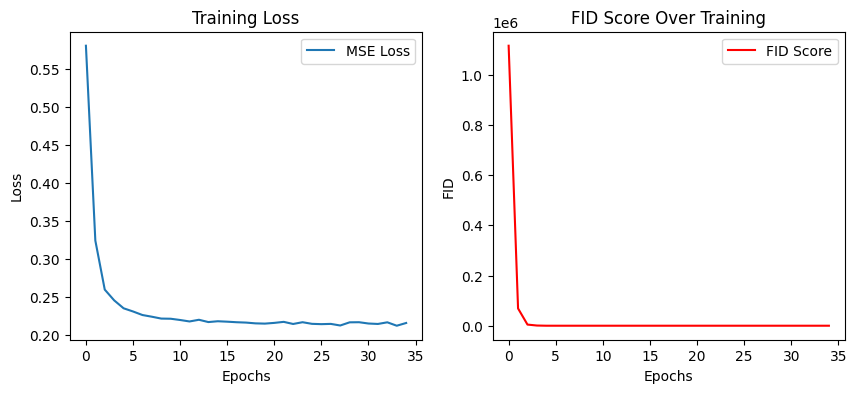

In [5]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="MSE Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fid_history, label="FID Score", color='r')
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.title("FID Score Over Training")
plt.legend()

plt.show()

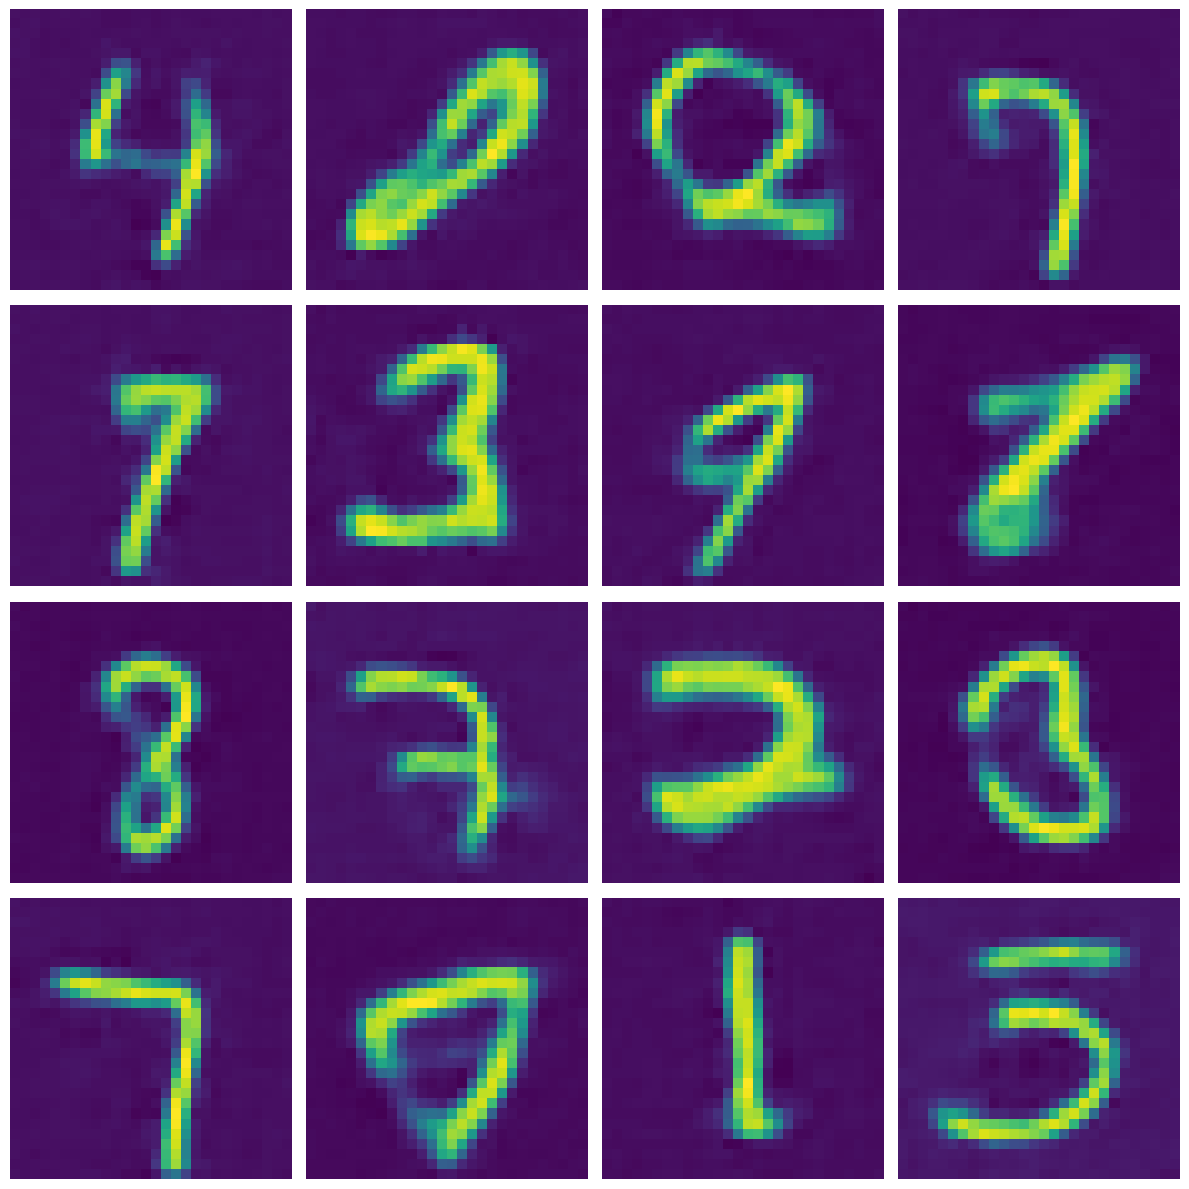

In [6]:
# from schedulers import DDIMSampler
sampler = DDIMSampler()
sampled_latent_images = sampler.sample(
    model=unet,
    n_samples=16,
    img_size=(1, 8, 8),  # For MNIST
    device=device,
    steps=100 # Can use fewer steps than training
)


# Create a figure with subplots
plt.figure(figsize=(12, 12))

# Plot each sample
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Remove channel dimension and move tensor to CPU
    img = unet.decode_vae(sampled_latent_images[i]).cpu().numpy()[0,0]
    # Plot image
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

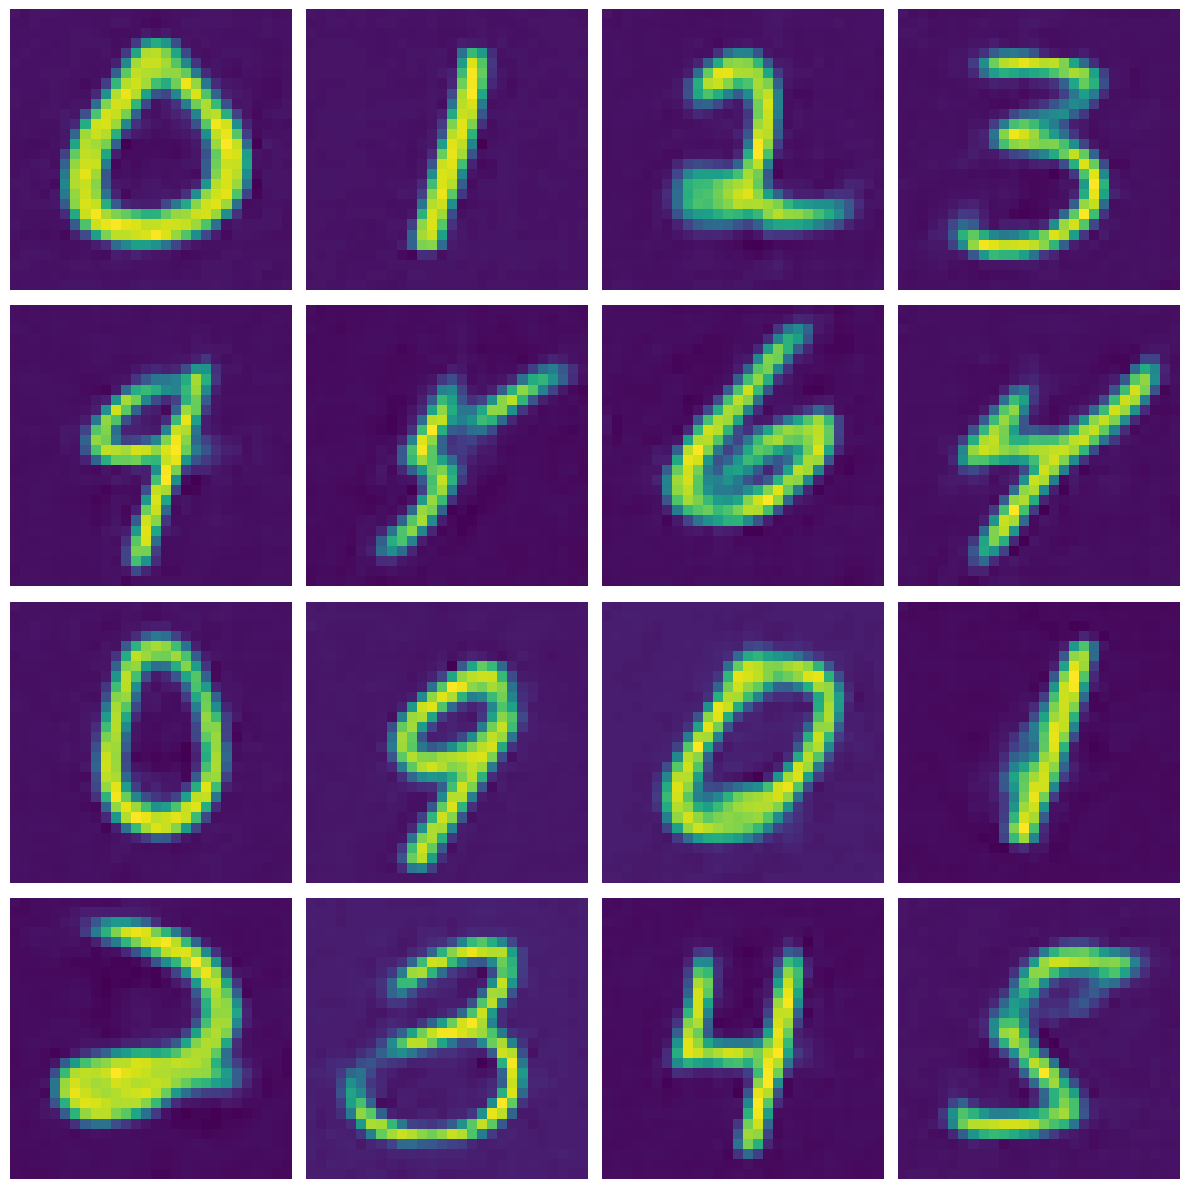

In [12]:
from schedulers import DDIMSampler
sampler = DDIMSampler()
sampled_latent_images = sampler.sample(
    model=unet,
    n_samples=16,
    img_size=(1, 8, 8),  # For MNIST
    device=device,
    steps=250, # Can use fewer steps than training
    condition = torch.LongTensor([0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5])
)


# Create a figure with subplots
plt.figure(figsize=(12, 12))

# Plot each sample
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Remove channel dimension and move tensor to CPU
    img = unet.decode_vae(sampled_latent_images[i]).cpu().numpy()[0,0]
    # Plot image
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()